In [7]:
import tensorflow as tf
from keras import layers, models, regularizers
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD
#from keras.callbacks import LearningRateScheduler
from keras.optimizers.schedules import ExponentialDecay
from keras.optimizers import SGD
import matplotlib.pyplot as plt
import optuna
import numpy as np




In [8]:
# Load and preprocess the dataset
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
train_images, test_images = train_images / 255.0, test_images / 255.0  # Normalize data
train_labels, test_labels = to_categorical(train_labels), to_categorical(test_labels)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
)
datagen.fit(train_images)

In [21]:
# Define the model
def create_model(weightDecay):
    model = models.Sequential()
    weightDecay = 0.0005
 

    # Adding regularization and BatchNormalization
    def conv_block(filters, model, kernal_size=(3,3), strides=(1,1), 
               padding='same', activation='relu'):
        model.add(layers.Conv2D(filters, kernal_size, strides=strides, 
                             padding=padding, 
                             kernel_regularizer=regularizers.l2(weightDecay),
                             input_shape=(32, 32, 3)))
        model.add(layers.Activation(activation))
        model.add(layers.BatchNormalization())
        return model

    # Simplified model structure with batch normalization and dropout
    model = conv_block(64, model)
    model.add(layers.Dropout(0.3))
    model = conv_block(64, model)
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    model = conv_block(128, model)
    model.add(layers.Dropout(0.4))
    model = conv_block(128, model)
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    model = conv_block(256, model)
    model.add(layers.Dropout(0.4))
    model = conv_block(256, model)
    model.add(layers.Dropout(0.4))
    model = conv_block(256, model)
    model.add(layers.MaxPooling2D((2, 2), strides=2))

    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(weightDecay)))
    model.add(layers.BatchNormalization())
    dropOutRate = 0.5
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax'))
    return model

weight_decay = 0.0005
dropOutRate = 0
model = create_model(weight_decay)
# Learning rate scheduling and compilation of the model
initial_learning_rate = 0.1
lr_schedule = ExponentialDecay(
    initial_learning_rate=initial_learning_rate,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

sgd = SGD(learning_rate=lr_schedule, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [10]:
# Training the model
batch_size = 64  # feel free to change it according to your system configuration
epochs = 10  # for better performance increase the number of epochs
history = model.fit(datagen.flow(train_images, train_labels, batch_size=batch_size),
                    steps_per_epoch=train_images.shape[0] // batch_size,
                    epochs=epochs,
                    validation_data=(test_images, test_labels),
                    verbose=2)


Epoch 1/10
781/781 - 396s - loss: 6.3637 - accuracy: 0.3276 - val_loss: 3.6478 - val_accuracy: 0.3206 - 396s/epoch - 507ms/step
Epoch 2/10
781/781 - 690s - loss: 2.4722 - accuracy: 0.4974 - val_loss: 2.0152 - val_accuracy: 0.5227 - 690s/epoch - 883ms/step
Epoch 3/10
781/781 - 691s - loss: 1.7045 - accuracy: 0.5806 - val_loss: 1.5493 - val_accuracy: 0.6301 - 691s/epoch - 885ms/step
Epoch 4/10
781/781 - 685s - loss: 1.5681 - accuracy: 0.6237 - val_loss: 1.6389 - val_accuracy: 0.6167 - 685s/epoch - 877ms/step
Epoch 5/10
781/781 - 688s - loss: 1.5300 - accuracy: 0.6468 - val_loss: 2.1978 - val_accuracy: 0.5022 - 688s/epoch - 881ms/step
Epoch 6/10
781/781 - 684s - loss: 1.5699 - accuracy: 0.6548 - val_loss: 1.9469 - val_accuracy: 0.5436 - 684s/epoch - 876ms/step
Epoch 7/10
781/781 - 641s - loss: 1.5885 - accuracy: 0.6643 - val_loss: 1.5460 - val_accuracy: 0.6885 - 641s/epoch - 820ms/step
Epoch 8/10
781/781 - 547s - loss: 1.5863 - accuracy: 0.6756 - val_loss: 1.5579 - val_accuracy: 0.6890 - 

In [11]:
# Evaluate the model
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 35s - loss: 1.4668 - accuracy: 0.7325 - 35s/epoch - 111ms/step

Test accuracy: 0.7325000166893005


In [12]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)


313/313 [==============================] - 36s 113ms/step


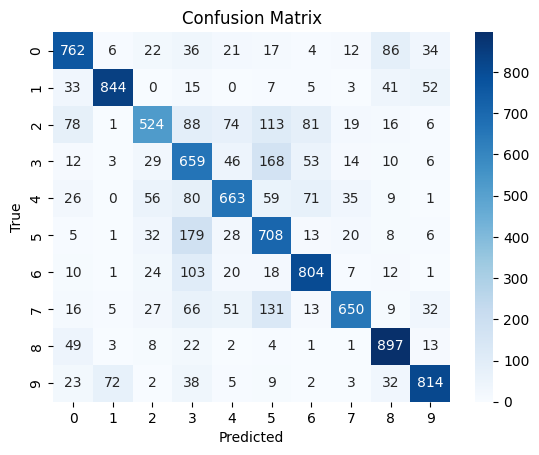

In [13]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_mtx = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(conf_mtx, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [14]:
from sklearn.metrics import classification_report

class_names = ['Class1', 'Class2', 'Class3', 'Class4', 'Class5', 'Class6', 'Class7', 'Class8', 'Class9', 'Class10']
print(classification_report(true_classes, predicted_classes, target_names=class_names))


              precision    recall  f1-score   support

      Class1       0.75      0.76      0.76      1000
      Class2       0.90      0.84      0.87      1000
      Class3       0.72      0.52      0.61      1000
      Class4       0.51      0.66      0.58      1000
      Class5       0.73      0.66      0.69      1000
      Class6       0.57      0.71      0.63      1000
      Class7       0.77      0.80      0.79      1000
      Class8       0.85      0.65      0.74      1000
      Class9       0.80      0.90      0.85      1000
     Class10       0.84      0.81      0.83      1000

    accuracy                           0.73     10000
   macro avg       0.75      0.73      0.73     10000
weighted avg       0.75      0.73      0.73     10000



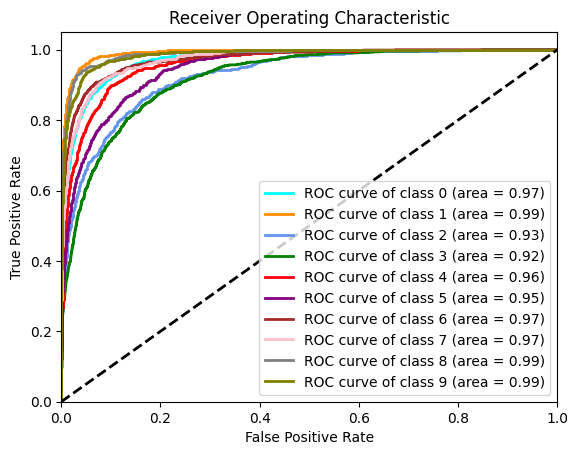

In [15]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

# Binarize the labels
bin_true_classes = label_binarize(true_classes, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
n_classes = bin_true_classes.shape[1]

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(bin_true_classes[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# HYPER PARAMETER OPTIMIZATION

In [24]:

def compile_and_train_model(model, num_epochs, batch_size, x_train, y_train, x_val, y_val):
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    history = model.fit(x_train, y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(x_val, y_val))
    return history

def objective(trial, x_test, y_test, x_train, y_train, x_val, y_val):
    # Suggested hyperparameters
    #dropout_rate = trial.suggest_uniform('dropout_rate', 0.1, 0.5)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)
    num_epochs = trial.suggest_int('num_epochs', 5, 50)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    
    
    # Create model with suggested hyperparameters
    model = create_model(weight_decay)
    
    history = compile_and_train_model(model, num_epochs, batch_size, x_train, y_train, x_val, y_val)
    
    # Evaluating the model
    _, accuracy = model.evaluate(x_test, y_test, verbose=0)
    return 1.0 - accuracy  # aim to maximize accuracy

# Optuna optimization
study = optuna.create_study(direction='maximize')
study.optimize(lambda trial: objective(trial, train_images, train_labels, test_images, test_labels, test_images, test_labels), n_trials=5)

# Print the result
best_params = study.best_params
best_score = study.best_value
print(f"The best parameters are {best_params} with a score of {best_score}")

[I 2023-10-13 15:50:54,919] A new study created in memory with name: no-name-52d3c991-4293-430e-9d99-beb53d8fc305
C:\Users\S_CSIS-PostGrad\AppData\Local\Temp\ipykernel_16632\3902587120.py:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-1)


Epoch 1/17
625/625 [==============================] - 189s 300ms/step - loss: 3.1582 - accuracy: 0.2977 - val_loss: 3.1111 - val_accuracy: 0.2884
Epoch 2/17
625/625 [==============================] - 201s 321ms/step - loss: 2.7412 - accuracy: 0.3940 - val_loss: 2.6122 - val_accuracy: 0.4222
Epoch 3/17
625/625 [==============================] - 93s 149ms/step - loss: 2.4928 - accuracy: 0.4572 - val_loss: 2.7173 - val_accuracy: 0.3908
Epoch 4/17
625/625 [==============================] - 93s 149ms/step - loss: 2.3340 - accuracy: 0.4885 - val_loss: 2.0166 - val_accuracy: 0.5775
Epoch 5/17
625/625 [==============================] - 94s 150ms/step - loss: 2.0921 - accuracy: 0.5531 - val_loss: 1.8657 - val_accuracy: 0.6130
Epoch 6/17
625/625 [==============================] - 95s 152ms/step - loss: 1.9306 - accuracy: 0.5858 - val_loss: 1.7276 - val_accuracy: 0.6409
Epoch 7/17
625/625 [==============================] - 95s 152ms/step - loss: 1.9233 - accuracy: 0.5993 - val_loss: 2.2422 - val_

[I 2023-10-13 16:40:11,951] Trial 0 finished with value: 0.3264399766921997 and parameters: {'weight_decay': 0.028465149189792698, 'num_epochs': 17, 'batch_size': 16}. Best is trial 0 with value: 0.3264399766921997.


Epoch 1/8
157/157 [==============================] - 165s 1s/step - loss: 3.1047 - accuracy: 0.3170 - val_loss: 5.8036 - val_accuracy: 0.1443
Epoch 2/8
157/157 [==============================] - 162s 1s/step - loss: 2.5853 - accuracy: 0.4404 - val_loss: 4.3815 - val_accuracy: 0.1428
Epoch 3/8
157/157 [==============================] - 162s 1s/step - loss: 2.3271 - accuracy: 0.4974 - val_loss: 4.0119 - val_accuracy: 0.1706
Epoch 4/8
157/157 [==============================] - 162s 1s/step - loss: 2.1177 - accuracy: 0.5497 - val_loss: 2.0980 - val_accuracy: 0.5403
Epoch 5/8
157/157 [==============================] - 162s 1s/step - loss: 1.9312 - accuracy: 0.5995 - val_loss: 2.2537 - val_accuracy: 0.5034
Epoch 6/8
157/157 [==============================] - 163s 1s/step - loss: 1.7663 - accuracy: 0.6498 - val_loss: 1.6290 - val_accuracy: 0.6927
Epoch 7/8
157/157 [==============================] - 164s 1s/step - loss: 1.6182 - accuracy: 0.6894 - val_loss: 2.4370 - val_accuracy: 0.4684
Epoch 

[I 2023-10-13 17:04:47,118] Trial 1 finished with value: 0.35005998611450195 and parameters: {'weight_decay': 0.0015639953095061543, 'num_epochs': 8, 'batch_size': 64}. Best is trial 1 with value: 0.35005998611450195.


Epoch 1/40
625/625 [==============================] - 200s 315ms/step - loss: 3.1238 - accuracy: 0.2965 - val_loss: 3.0432 - val_accuracy: 0.2943
Epoch 2/40
625/625 [==============================] - 196s 313ms/step - loss: 2.5947 - accuracy: 0.4133 - val_loss: 7.4959 - val_accuracy: 0.2376
Epoch 3/40
625/625 [==============================] - 193s 309ms/step - loss: 2.5537 - accuracy: 0.4479 - val_loss: 2.8663 - val_accuracy: 0.3872
Epoch 4/40
625/625 [==============================] - 186s 298ms/step - loss: 2.3439 - accuracy: 0.4977 - val_loss: 2.2403 - val_accuracy: 0.5266
Epoch 5/40
625/625 [==============================] - 76177s 122s/step - loss: 2.1720 - accuracy: 0.5368 - val_loss: 1.9295 - val_accuracy: 0.6032
Epoch 6/40
625/625 [==============================] - 203s 325ms/step - loss: 1.9868 - accuracy: 0.5759 - val_loss: 1.7564 - val_accuracy: 0.6528
Epoch 7/40
625/625 [==============================] - 202s 323ms/step - loss: 1.9207 - accuracy: 0.6033 - val_loss: 1.7899 

[I 2023-10-14 15:48:09,220] Trial 2 finished with value: 0.25568002462387085 and parameters: {'weight_decay': 0.0003997383799694358, 'num_epochs': 40, 'batch_size': 16}. Best is trial 1 with value: 0.35005998611450195.


Epoch 1/44
79/79 [==============================] - 184s 2s/step - loss: 3.1382 - accuracy: 0.3143 - val_loss: 4.8440 - val_accuracy: 0.1000
Epoch 2/44
79/79 [==============================] - 181s 2s/step - loss: 2.6891 - accuracy: 0.4100 - val_loss: 5.6243 - val_accuracy: 0.1000
Epoch 3/44
79/79 [==============================] - 177s 2s/step - loss: 2.4324 - accuracy: 0.4859 - val_loss: 4.4235 - val_accuracy: 0.1399
Epoch 4/44
79/79 [==============================] - 182s 2s/step - loss: 2.2397 - accuracy: 0.5379 - val_loss: 4.3275 - val_accuracy: 0.1897
Epoch 5/44
79/79 [==============================] - 176s 2s/step - loss: 2.0991 - accuracy: 0.5718 - val_loss: 3.1288 - val_accuracy: 0.2578
Epoch 6/44
79/79 [==============================] - 173s 2s/step - loss: 1.9460 - accuracy: 0.6181 - val_loss: 2.5088 - val_accuracy: 0.4100
Epoch 7/44
79/79 [==============================] - 172s 2s/step - loss: 1.8201 - accuracy: 0.6516 - val_loss: 2.2974 - val_accuracy: 0.4631
Epoch 8/44
79

[I 2023-10-14 17:51:34,817] Trial 3 finished with value: 0.2686399817466736 and parameters: {'weight_decay': 0.011199739374906823, 'num_epochs': 44, 'batch_size': 128}. Best is trial 1 with value: 0.35005998611450195.


Epoch 1/32
79/79 [==============================] - 58s 720ms/step - loss: 3.1314 - accuracy: 0.3190 - val_loss: 4.2400 - val_accuracy: 0.1000
Epoch 2/32
79/79 [==============================] - 56s 710ms/step - loss: 2.6616 - accuracy: 0.4177 - val_loss: 4.1878 - val_accuracy: 0.1007
Epoch 3/32
79/79 [==============================] - 55s 698ms/step - loss: 2.4250 - accuracy: 0.4908 - val_loss: 3.8955 - val_accuracy: 0.1932
Epoch 4/32
79/79 [==============================] - 53s 669ms/step - loss: 2.2503 - accuracy: 0.5301 - val_loss: 3.9265 - val_accuracy: 0.1633
Epoch 5/32
79/79 [==============================] - 58s 733ms/step - loss: 2.1239 - accuracy: 0.5634 - val_loss: 4.0952 - val_accuracy: 0.2125
Epoch 6/32
79/79 [==============================] - 60s 755ms/step - loss: 1.9644 - accuracy: 0.6062 - val_loss: 2.7971 - val_accuracy: 0.3499
Epoch 7/32
79/79 [==============================] - 61s 779ms/step - loss: 1.8607 - accuracy: 0.6383 - val_loss: 2.3908 - val_accuracy: 0.4783

[I 2023-10-14 19:13:57,296] Trial 4 finished with value: 0.2763599753379822 and parameters: {'weight_decay': 0.0014413309480206097, 'num_epochs': 32, 'batch_size': 128}. Best is trial 1 with value: 0.35005998611450195.


The best parameters are {'weight_decay': 0.0015639953095061543, 'num_epochs': 8, 'batch_size': 64} with a score of 0.35005998611450195
